In [25]:
# https://graphsandnetworks.com/the-cora-dataset/

In [1]:
import os
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset_loc = './datasets/cora'

In [3]:
df = pd.read_csv(os.path.join(dataset_loc, "cora.cites"), sep='\t', header=None, names=["target", "source"])

In [4]:
graph = nx.from_pandas_edgelist(df)

In [9]:
def random_walk(node, walk_length):
    walk = []
    walk.append(node)
    
    while walk_length - 1 > 0:
        neighbors = list(graph.neighbors(node))
        node = random.choice(neighbors)
        walk.append(node)
        walk_length = walk_length - 1
    
    return walk

In [10]:
random_walk(1033, 5)

[1033, 45605, 1033, 35, 579008]

In [26]:
class DeepWalk:
    def __init__(self, graph):
        self.graph = graph
        self.nodes = list(graph.nodes)
        
    def random_walk(self, node, walk_length):
        walk = [node]

        while walk_length - 1 > 0:
            neighbors = list(self.graph.neighbors(node))
            node = random.choice(neighbors)
            walk.append(node)
            walk_length = walk_length - 1

        return walk
    
    def generate_train_samples(self, num_samples, walk_length):
        X = []
        for sid in tqdm(range(num_samples)):
            node = random.choice(self.nodes)
            walk = self.random_walk(node, walk_length)
            X.append(walk)
        return X
    
    def train(self, X, embed_dim = 128, window = 5, min_count = 1, workers = 4):
        w2v = Word2Vec(sentences = X, 
              vector_size = embed_dim, 
              window = window, 
              min_count = min_count, 
              workers = workers)
        return w2v

In [25]:
dw = DeepWalk(graph)
trainX = dw.generate_train_samples(50000, 128)
print('[x] model training ...')
model = dw.train(trainX, 256)
print('[x] model saving ...')
model.save('myw2v.model')

100%|█████████████████████████████| 50000/50000 [00:05<00:00, 8380.08it/s]


[x] model training ...
[x] model training ...
[x] model saving ...


In [17]:
content = pd.read_csv(os.path.join(dataset_loc, "cora.content"), sep='\t', header=None)[[0, 1434]]
content.rename({0: 'node', 1434: 'type'}, axis = 1, inplace = True)
k2i = pd.DataFrame({'node': model.wv.key_to_index.keys(), 'vindex': model.wv.key_to_index.values()})
meta_df = pd.merge(content, k2i, on = 'node').sort_values('vindex')

In [19]:
meta_df

,node,type,vindex
163,35,Genetic_Algorithms,0
565,6213,Reinforcement_Learning,1
747,1365,Neural_Networks,2
427,3229,Neural_Networks,3
611,910,Neural_Networks,4
...,...,...,...
2392,594039,Genetic_Algorithms,2703
387,325314,Neural_Networks,2704
762,1104261,Theory,2705
2145,1116181,Theory,2706


In [20]:
model.wv.vector_size // 2

128

In [21]:
pca = PCA(n_components=2)
x = pca.fit_transform(model.wv.vectors)

In [22]:
meta_df['pca_x'] = x[:, 0]
meta_df['pca_y'] = x[:, 1]
meta_df['type_int'] = LabelEncoder().fit_transform(meta_df['type'])

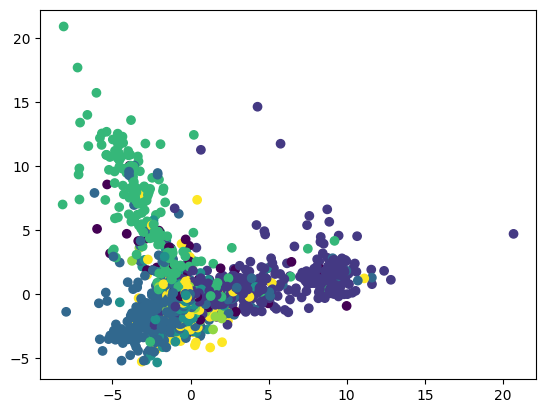

In [23]:
plt.scatter(meta_df['pca_x'], meta_df['pca_y'], c=meta_df['type_int'])
plt.show()